In [4]:
using LinearAlgebra
using SymPy
using BlockArrays
using Plots
using SparseArrays

Composable Gaussian Integration

I must have more notes on this somewhere

Linearly constrained quadratic programs and Gaussian integration solve roughly the same problem.



Dirac delta functions are very very useful. They can be conceived as a the limit of very sharply peaked Gaussians. If we want to have something compositional and categorically flavored, we need to include them, as they are the idnetity morphisms of integration


There is a smorgabrog of notions of composition where inner variables are somehow integrated or projected out. Examples include matrix multiplication $\sum$, integratin $\int$, relational composition $\exists$, and shortest path/compositional optimization $\min$ .
Interestingly, function composition, the canonical example of composition, using lambda binders doesn't obviously take this form.




The pullback is one way of categorically describing solving a set of affine equations


f.A * x + f.b = g.A * y + g.b

[f.A ; -g.A] [x ; y] = g.b - f.b

We need to build generators. 

nullspace(Q) + solution

[f.A  -g.A  (f.b - g.b)] [x ; y ; 1] = 0

maybe this doesn't get us any extra info.


Hmm. As it is set up, even if I have no solutions (0 dimensional space) there still is an offset vector. No solutions ought to be expressible.
Maybe affine maps don't have a pullback generally?



In [39]:
module Testy

struct AffCat
    A
    b
end

struct QuadFun
    Q # symmettric matrix
    c # vector 
    r # constant. Not super relevant often
end

end

Main.Testy

In [40]:
using Main.Testy: AffCat, QuadFun

In [26]:
e = AffCat([1 2; 3 4], [1 ; 2])

AffCat([1 2; 3 4], [1, 2])

In [18]:
Base.:∘(f::AffCat, g::AffCat) = AffCat( f.A * g.A , f.b + f.A*g.b )

In [31]:
dom(f::AffCat) = size(f.A)[2]
cod(f::AffCat) = size(f.A)[1]

cod (generic function with 1 method)

In [33]:
id(n) = AffCat(I, zeros(n))

id (generic function with 1 method)

In [37]:
id(2) ∘ id(2) ∘ e

AffCat([1 2; 3 4], [1.0, 2.0])

In [41]:
Base.:+(x::QuadFun, y::QuadFun ) = QuadFun(x.Q + y.Q, x.c + y.c, x.r + y.r)

Let's just talk about Schur complemnts. They're fun and must surely be a cornerstone of all this

The Schur complement is an interesting intermediate calculation that occurs when you solve a block matrix.


Consider a 2x2 matrix


In [2]:
@vars a b c d

(a, b, c, d)

In [6]:
A = Matrix([a b ; 
            c d])

2×2 Array{Sym,2}:
 a  b
 c  d

In [16]:
R = Matrix( [ 1    0 ;
             -c/a  1 ]  ) 
U = R * A
L = inv(R)

2×2 Array{Sym,2}:
   1  0
 c/a  1

In [18]:
A2 = sympy.MatMul(L , U)
Eq(A2 , A2.doit())

⎡1  0⎤ ⎡a     b   ⎤         
⎢    ⎥ ⎢          ⎥   ⎡a  b⎤
⎢c   ⎥⋅⎢       b⋅c⎥ = ⎢    ⎥
⎢─  1⎥ ⎢0  d - ───⎥   ⎣c  d⎦
⎣a   ⎦ ⎣        a ⎦         

In [14]:
sympy.MatMul(inv(R) , A2).doit()

⎡a  b⎤
⎢    ⎥
⎣c  d⎦

In [20]:
@vars a b c d commutative=false

(a, b, c, d)

In [22]:
simplify(a * b - b * a) # can't do it

a⋅b - b⋅a

In [29]:
L = Matrix([ 1          0 ;
              c * inv(a) 1 ])
schur = d - c * inv(a) * b
U =  Matrix([ a         b ;
              0         schur ])

L * U

2×2 Array{Sym,2}:
 a  b
 c  d

In [36]:
K = SymTridiagonal( fill(2, 10), fill(-1, 9) )

10×10 SymTridiagonal{Int64,Array{Int64,1}}:
  2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2

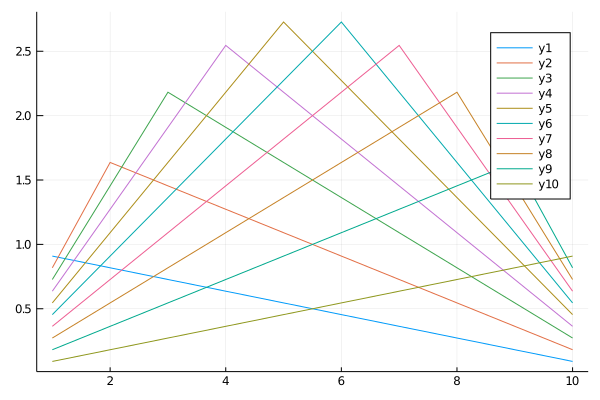

In [39]:
plot(inv(K))

In [41]:
j = zeros(10)
j[3] = 1

1

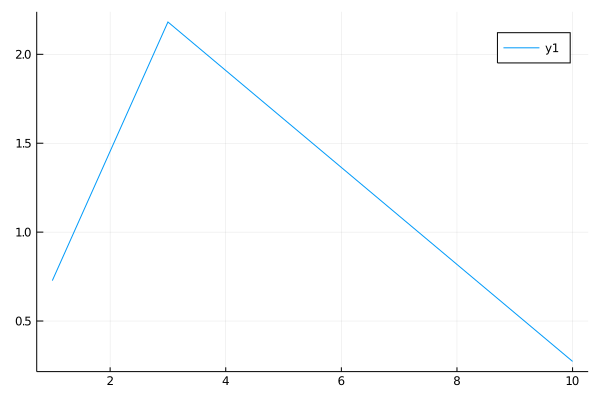

In [43]:
plot(K \ j)

In [88]:


K = SymTridiagonal( fill(2.0, 10), fill(-1.0, 9) )
Kb = BlockArray(sparse(K), [8,2], [8,2])
Kb[Block(2,2)] \ Array(Kb[Block(2,1)])

2×8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  -0.666667
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  -0.333333

In [89]:
schurC(A) = A[Block(1,1)] - A[Block(1,2)] * (A[Block(2,2)] \ Array(A[Block(2,1)])  )

schurC (generic function with 1 method)

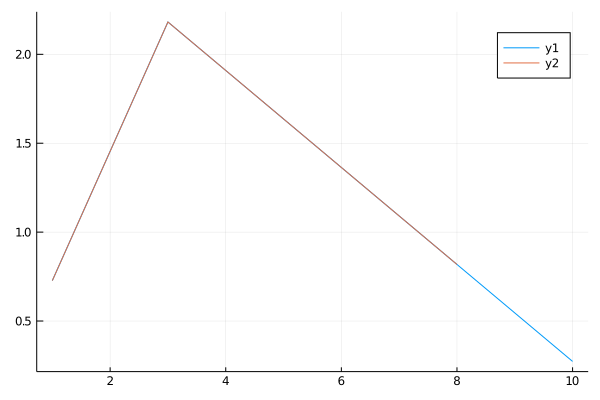

In [94]:
plot(K \ j)
plot!(schurC(Kb) \  j[1:8])


In [66]:
transpose(Kb[Block(1,2)])

2×8 Transpose{Int64,SparseMatrixCSC{Int64,Int64}}:
 0  0  0  0  0  0  0  -1
 0  0  0  0  0  0  0   0

Gausian elimination encapsulates the process of completing the square


Completing the square is a method by which to perform gaussian integrals. You complete the square on each variable in turn and then do u substitution to make the new integration variable the quantity in the square.







In [35]:
simplify( a * x ^2 + 2b * x * y + d * y^2  - a * ( x + y * b / a )^2) # the "leftover" from completing the square on x

 2 ⎛       2⎞
y ⋅⎝a⋅d - b ⎠
─────────────
      a      

In [41]:
orig = a * x ^2 + 2b * x * y + d * y^2 
comp_sq =  a * ( x + y * b / a )^2   +   y^2 * (d - b^2 / a)
@assert simplify(orig - comp_sq).is_zero

In [52]:
lu([ orig.coeff(v * w) / (if (v == w) 1 else 2 end) for v in [x, y], w in [x, y] ])

LU{Sym,Array{Sym,2}}
L factor:
2×2 Array{Sym,2}:
   1  0
 b/a  1
U factor:
2×2 Array{Sym,2}:
 a          b
 0  d - b^2/a

In [55]:
comp_square(e,x) = let z = e.coeff(x^2) * (x +  e.coeff(x) / e.coeff(x^2) / 2  ) ^ 2 
                   z + simplify(  e - z  )
                   end

comp_square (generic function with 1 method)

In [61]:
@assert simplify(comp_square(orig, x) - orig).is_zero
comp_square(orig,x)

           2    2 ⎛       2⎞
  ⎛    b⋅y⎞    y ⋅⎝a⋅d - b ⎠
a⋅⎜x + ───⎟  + ─────────────
  ⎝     a ⎠          a      

In [27]:
@vars x y a b c d real=true
i = exp( - ( a * x^2 + b * x * y + b * y * x + d * y * y )   )

      2                2
 - a⋅x  - 2⋅b⋅x⋅y - d⋅y 
ℯ                       

In [28]:
r = simplify(integrate(i, (x,-oo,oo)))
r.args[1]

⎛       ⎛      2⎞                                                             
⎜     2 ⎜     b ⎟                                                             
⎜    y ⋅⎜-d + ──⎟                                                             
⎜       ⎝     a ⎠                                                             
⎜√π⋅ℯ              ⎛                            π   │                 ⎛       
⎜────────────────, ⎜│periodic_argument(a, ∞)│ ≤ ─ ∧ │periodic_argument⎝polar_l
⎝       √a         ⎝                            2                             

                                                                              
                                                                              
                                                                              
                                                                              
   2              2      ⎞│       │                 ⎛ 2⋅ⅈ⋅π           2       
ift (b)⋅polar_lift (y), ∞⎠│ < π ∧ │periodic_argumen

In [30]:
top = r.args[1].args[1].args[3].args[1]
top # look familiar?

   ⎛      2⎞
 2 ⎜     b ⎟
y ⋅⎜-d + ──⎟
   ⎝     a ⎠

In [ ]:
struct Quad 
    A
    b
    c
end


A = BlockArray(rand(4, 5), [1,3], [2,3])
#A[Block(1,2)]
#blockaxes(A)
#BlockArrays.blocklengths(A)
blocksize(A)
A[Block(1,1)]
blockaxes(A)


function compose( f :: Quad, g :: Quad)
    A = f[Block(2,2)] + g[Block(1,1)]
    Q = BlockArray(  [f[Block(1,1 )]    0          ; 
                       0              g[Block(2,2)]    ) 
    return  Q -  [ f[] ;  g[]   ]  * inv(A)
    
    
end
        
        
        @vars n m
A = sympy.MatrixSymbol("A", n,n)
B = sympy.MatrixSymbol("B", n,m)
C = sympy.MatrixSymbol("C", m,n)
D = sympy.MatrixSymbol("D", m,m)
x = sympy.MatrixSymbol("x", n,1)
y = sympy.MatrixSymbol("y", m,1)

t = sympy.MatrixSymbol("t", n,1)
s = sympy.MatrixSymbol("s", m,1)
        
        Q = sympy.BlockMatrix( [A B ; C D] ) 
v = sympy.BlockMatrix(  [x ; y] )
        
        (v.T * Q  * v) + t.T * x + s.T * y